<a href="https://colab.research.google.com/github/Kalisa21/SmartCiti/blob/main/notebook/TrafficSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib

In [2]:
# --- Step 1: Load Dataset ---
df = pd.read_csv("Traffic.csv")

# --- Step 2: Data Preprocessing ---
def preprocess_data(df, fit_scaler=True, scaler=None, label_encoder=None, is_prediction=False):
    """Preprocess the dataset: feature engineering, encoding, scaling."""
    df_processed = df.copy()

    if not is_prediction:
        df_processed['Hour'] = pd.to_datetime(df_processed['Time'], format='%I:%M:%S %p').dt.hour
        df_processed = df_processed.drop(columns=['Time', 'Date', 'Day of the week'])

    if 'Vehicle_Density' not in df_processed.columns:
        df_processed['Vehicle_Density'] = df_processed['Total'] / 4
    if 'Heavy_Vehicle_Ratio' not in df_processed.columns:
        df_processed['Heavy_Vehicle_Ratio'] = (df_processed['BusCount'] + df_processed['TruckCount']) / df_processed['Total'].replace(0, 1)

    if not is_prediction:
        if label_encoder is None:
            label_encoder = LabelEncoder()
            df_processed['Traffic Situation'] = label_encoder.fit_transform(df_processed['Traffic Situation'])
        else:
            df_processed['Traffic Situation'] = label_encoder.transform(df_processed['Traffic Situation'])
        X = df_processed.drop(columns=['Traffic Situation'])
        y = df_processed['Traffic Situation']
    else:
        X = df_processed
        y = None

    if fit_scaler:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, y, scaler, label_encoder

In [3]:
# --- Step 3: Data Visualization ---
def create_visualizations(df):
    df['Hour'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.hour
    fig1 = px.box(df, x='Traffic Situation', y='CarCount', title='Car Count Distribution by Traffic Situation')
    fig1.show()
    fig2 = px.scatter(df, x='Hour', y='Total', color='Traffic Situation', title='Total Vehicles by Hour', opacity=0.5)
    fig2.show()
    df['Heavy_Vehicle_Ratio'] = (df['BusCount'] + df['TruckCount']) / df['Total'].replace(0, 1)
    fig3 = px.violin(df, x='Traffic Situation', y='Heavy_Vehicle_Ratio', title='Heavy Vehicle Ratio by Traffic Situation')
    fig3.show()

In [4]:
# --- Step 4: Model Training ---
def train_model(X_train, y_train, X_val, y_val, pretrained_model_path=None):
    if pretrained_model_path:
        model = tf.keras.models.load_model(pretrained_model_path)
    else:
        model = Sequential([
            Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(4, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

    return model, history

In [5]:
# --- Step 5: Model Evaluation ---
def evaluate_model(model, X_test, y_test, label_encoder, title="Confusion Matrix"):
    y_pred = model.predict(X_test).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\nEvaluation Metrics for {title}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [6]:
# --- Step 6: Prediction ---
def predict_traffic(model, scaler, label_encoder, input_data):
    total = input_data['CarCount'] + input_data['BikeCount'] + input_data['BusCount'] + input_data['TruckCount']
    vehicle_density = total / 4
    heavy_vehicle_ratio = (input_data['BusCount'] + input_data['TruckCount']) / total if total > 0 else 0
    input_df = pd.DataFrame([{
        'CarCount': input_data['CarCount'],
        'BikeCount': input_data['BikeCount'],
        'BusCount': input_data['BusCount'],
        'TruckCount': input_data['TruckCount'],
        'Total': total,
        'Hour': input_data['Hour'],
        'Vehicle_Density': vehicle_density,
        'Heavy_Vehicle_Ratio': heavy_vehicle_ratio
    }])
    X_scaled, _, _, _ = preprocess_data(input_df, fit_scaler=False, scaler=scaler, label_encoder=label_encoder, is_prediction=True)
    pred = model.predict(X_scaled).argmax(axis=1)
    return label_encoder.inverse_transform(pred)[0]

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4241 - loss: 2.5566 - val_accuracy: 0.7294 - val_loss: 1.6293
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7596 - loss: 1.5138 - val_accuracy: 0.8571 - val_loss: 1.1411
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8364 - loss: 1.1080 - val_accuracy: 0.9008 - val_loss: 0.8964
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8913 - loss: 0.8529 - val_accuracy: 0.8941 - val_loss: 0.7636
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8694 - loss: 0.7448 - val_accuracy: 0.9126 - val_loss: 0.6535
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8871 - loss: 0.6670 - val_accuracy: 0.8874 - val_loss: 0.6031
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8921 - loss: 0.5957 - val_accuracy: 0.8958 - val_loss: 0.5727
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8929 - loss: 0.5642 - val_accuracy: 0.9076 - val_loss: 0.

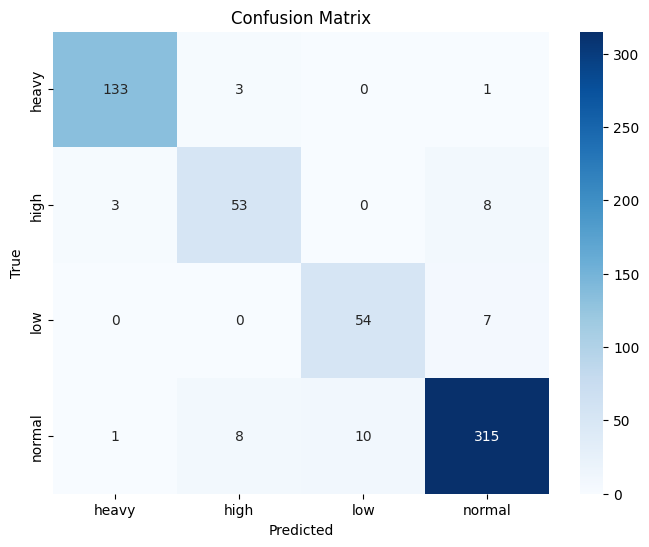

In [7]:
# --- Main Execution ---
X, y, scaler, label_encoder = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
model, history = train_model(X_train, y_train, X_val, y_val)
evaluate_model(model, X_test, y_test, label_encoder)
model.save('traffic_model.keras')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
create_visualizations(df)


In [11]:
# Interactive prediction input
print("\nEnter your traffic data for prediction:")
car_count   = int(input("CarCount: "))
bike_count  = int(input("BikeCount: "))
bus_count   = int(input("BusCount: "))
truck_count = int(input("TruckCount: "))
hour        = int(input("Hour (0-23): "))
day_of_week = int(input("Day of Week (0-6, where 0=Monday, 6=Sunday): "))

input_data = {
    'CarCount':   car_count,
    'BikeCount':  bike_count,
    'BusCount':   bus_count,
    'TruckCount': truck_count,
    'Hour':       hour,
    'DayOfWeek':  day_of_week
}

prediction = predict_traffic(model, scaler, label_encoder, input_data)
print(f"\nPredicted Traffic Situation: {prediction}")


Enter your traffic data for prediction:
CarCount: 12
BikeCount: 12
BusCount: 12
TruckCount: 12
Hour (0-23): 12
Day of Week (0-6, where 0=Monday, 6=Sunday): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predicted Traffic Situation: normal
